In [1]:
import paho.mqtt.client as mqtt
import json
import time

In [2]:
import paho.mqtt.client as mqtt
import json
import time

MQTT_BROKER = "mqtt-dashboard.com"
MQTT_PORT = 1883
MQTT_TOPIC_PID = "robot/set/pid"
MQTT_TOPIC_MOTORS = "robot/set/motors"
MQTT_TOPIC_LOG = "robot/pid/log"
MQTT_TOPIC_RESPONSE = "robot/request"

In [3]:
mqtt_client = mqtt.Client("PID ctl")

logs = []

experiment_ongoing = False

In [4]:
def send_mqtt_message(topic, message):
    mqtt_client.publish(topic, json.dumps(message))

In [20]:
def run_experiment(Kp, Ti, Td):
    global logs
    global mqtt_client
    global experiment_ongoing
    mqtt_client = mqtt.Client("PID ctl")
    mqtt_client.connect(MQTT_BROKER, MQTT_PORT)
    mqtt_client.subscribe(MQTT_TOPIC_LOG)
    mqtt_client.on_message = on_log_message

    mqtt_client.loop()
    logs = []

    pid_settings = {"Kp": Kp, "Ti": Ti, "Td": Td}
    send_mqtt_message(MQTT_TOPIC_PID, pid_settings)

    motors_speed = {"left": 40, "right": 40}
    send_mqtt_message(MQTT_TOPIC_MOTORS, motors_speed)
    experiment_ongoing = True
    start_time = time.time()
    while time.time() - start_time < 4:
        mqtt_client.loop()

    motors_speed = {"left": 0, "right": 0}
    send_mqtt_message(MQTT_TOPIC_MOTORS, motors_speed)

    while time.time() - start_time < 4:
        mqtt_client.loop()
    
    send_mqtt_message(MQTT_TOPIC_RESPONSE, "")
    experiment_ongoing = False
    mqtt_client.disconnect()

def on_log_message(client, userdata, message):
    global experiment_ongoing
    log_data = json.loads(message.payload.decode())
    if len(logs) != 0: 
        logs.append(log_data) 
    elif len(logs) == 0 and log_data["id"] == 0:
        logs.append(log_data)

In [6]:
mqtt_client.subscribe(MQTT_TOPIC_LOG)
mqtt_client.on_message = on_log_message

In [7]:
import math
def calc_error(Kp, Ti, Td):
    global logs

    absolute_errors = []
    relative_errors = []
    settling_times = []

    sampling_time = 5

    run_experiment(Kp, Ti, Td)

    for i in range(len(logs)):
        measurement = logs[i]
        absolute_error = abs(measurement['target'] - measurement['actual'])
        relative_error = (absolute_error / measurement['target']) * 100 if measurement['target'] != 0 else 0
        absolute_errors.append(absolute_error)
        relative_errors.append(relative_error)
        
        # Sprawdzenie, czy wartość docelowa została osiągnięta
        if relative_error < 2:  # Możesz dostosować wartość graniczną według potrzeb
            settling_time = i * sampling_time
            settling_times.append(settling_time)

    mean_error = sum(absolute_errors) / len(absolute_errors)

    mean_relative_error = sum(relative_errors) / len(relative_errors)

    rmse_error = math.sqrt(sum([(error ** 2) for error in absolute_errors]) / len(absolute_errors))

    average_settling_time = sum(settling_times) / len(settling_times) if settling_times else None

    # Wyświetlenie wyników
    print("Mean error: ", mean_error)
    print("Mean relative error: ", mean_relative_error)
    print("(RMSE): ", rmse_error)
    print("Average settling time: ", average_settling_time, " ms")

    print(logs)

In [8]:
PID_settings = [
    { "Kp" : 11.98725113, "Ti" : 1.59488759, "Td" : 1.34889701 },
    { "Kp" : 29.50415103, "Ti" : 14.54508991, "Td" : 1.37240407 },
    { "Kp" : 6.48107301, "Ti" : 2.93091131, "Td" : 2.34173984 },
    { "Kp" : 0.040005524963476743, "Ti" : 0.6951230685936127, "Td" : 0.16682953646246704 }
]

# for setting in PID_settings:
#     print(setting)
#     calc_error(setting["Kp"], setting["Ti"], setting["Td"])

In [37]:
setting = PID_settings[2]
calc_error(setting["Kp"], setting["Ti"], setting["Td"])

Mean error:  0.6466616084977226
Mean relative error:  9.680563001462943
(RMSE):  1.3949048297524695
Average settling time:  2030.8851674641148  ms
[{'id': 0, 'target': 6.68, 'actual': 0.0}, {'id': 1, 'target': 6.68, 'actual': 0.0}, {'id': 2, 'target': 6.68, 'actual': 0.2}, {'id': 3, 'target': 6.68, 'actual': 0.14}, {'id': 4, 'target': 6.68, 'actual': 0.29}, {'id': 5, 'target': 6.68, 'actual': 0.4}, {'id': 6, 'target': 6.68, 'actual': 0.67}, {'id': 7, 'target': 6.68, 'actual': 0.67}, {'id': 8, 'target': 6.68, 'actual': 0.86}, {'id': 9, 'target': 6.68, 'actual': 0.99}, {'id': 10, 'target': 6.68, 'actual': 1.09}, {'id': 11, 'target': 6.68, 'actual': 1.16}, {'id': 12, 'target': 6.68, 'actual': 1.2}, {'id': 13, 'target': 6.68, 'actual': 1.23}, {'id': 14, 'target': 6.68, 'actual': 1.45}, {'id': 15, 'target': 6.68, 'actual': 1.41}, {'id': 16, 'target': 6.68, 'actual': 1.58}, {'id': 17, 'target': 6.68, 'actual': 1.69}, {'id': 18, 'target': 6.68, 'actual': 1.77}, {'id': 19, 'target': 6.68, 'act

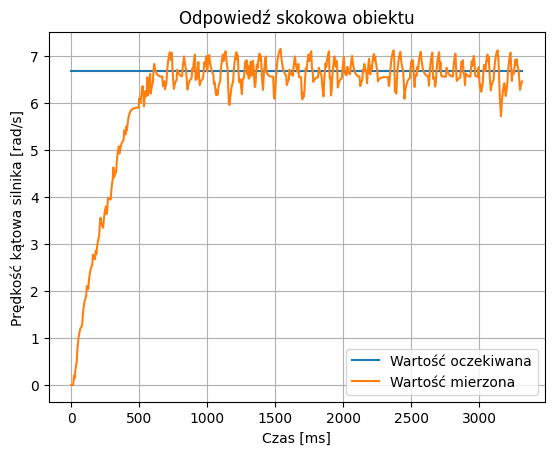

In [36]:
import matplotlib.pyplot as plt

time_step_ms = 5

# Tworzenie listy czasów
times_ms = [log['id'] * time_step_ms for log in logs]
targets = [log['target'] for log in logs]
actuals = [log['actual'] for log in logs]

# Tworzenie wykresu
plt.plot(times_ms, targets, label='Wartość oczekiwana')
plt.plot(times_ms, actuals, label='Wartość mierzona')

# Dodanie etykiet i tytułu
plt.xlabel('Czas [ms]')
plt.ylabel('Prędkość kątowa silnika [rad/s]')
plt.title('Odpowiedź skokowa obiektu')
plt.legend()

# Wyświetlenie wykresu
plt.grid(True)
plt.show()

In [93]:
print(actuals)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.65, 0.0, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 1.31, 0.65, 1.31, 0.65, 1.31, 1.31, 1.31, 1.31, 1.96, 1.31, 1.31, 1.31, 1.96, 1.96, 1.31, 1.96, 1.96, 1.96, 1.96, 2.62, 2.62, 2.62, 1.96, 1.96, 1.96, 2.62, 2.62, 2.62, 2.62, 2.62, 2.62, 3.27, 3.27, 3.27, 2.62, 2.62, 2.62, 2.62, 3.27, 3.27, 3.27, 2.62, 2.62, 3.27, 3.27, 3.93, 3.27, 3.93, 3.93, 3.27, 3.27, 3.93, 3.93, 3.93, 3.27, 3.93, 3.27, 4.58, 3.93, 3.27, 3.93, 3.27, 3.27, 4.58, 4.58, 4.58, 3.93, 3.93, 3.93, 4.58, 4.58, 4.58, 3.93, 3.93, 3.93, 5.24, 4.58, 3.93, 3.93, 3.93, 4.58, 3.27, 3.93, 4.58, 3.93, 3.93, 3.93, 4.58, 3.93, 5.24, 3.93, 3.93, 3.93, 4.58, 5.24, 5.24, 5.24, 5.24, 4.58, 4.58, 5.24, 5.24, 5.24, 4.58, 3.93, 3.93, 4.58, 5.89, 5.24, 5.24, 4.58, 5.24, 5.89, 5.24, 4.58, 4.58, 3.93, 5.24, 5.24, 4.58, 4.58, 5.24, 4.58, 5.89, 5.24, 5.24, 4.58, 4.58, 4.58, 5.89, 5.24, 5.89, 5.89, 5.89, 5.89, 5.24, 5.89, 5.24, 4.58, 5.89, 5.89, 4.58, 4.58, 4.58, 5.89, 5.89, 5.89, 5.89, 5.89, 5.24, 4.58, 4

In [94]:
import numpy as np
from scipy.optimize import curve_fit

# Dane czasowe (w sekundach)
time_step = 5 / 1000  # 5ms to sekundy
t = np.arange(0, len(actuals) * time_step, time_step)

# Dane odpowiedzi skokowej
odpowiedź_skokowa = actuals  # Dane podane przez Ciebie

# Funkcja transmitancji pierwszego rzędu
def first_order_transfer_function(t, K, T):
    return K * (1 - np.exp(-t / T))

# Dopasowanie funkcji do danych za pomocą regresji liniowej
popt, pcov = curve_fit(first_order_transfer_function, t, odpowiedź_skokowa)

# Odczytanie wartości K i T
K, T = popt

print("Wzmocnienie (K):", K)
print("Stała czasowa (T):", T)

Wzmocnienie (K): 6.365318519867311
Stała czasowa (T): 0.4425290896955204


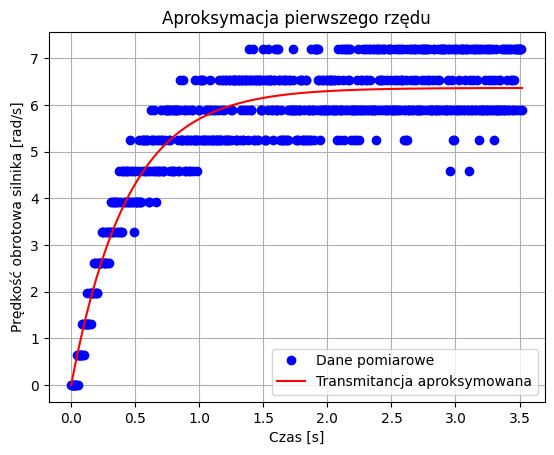

In [97]:
import matplotlib.pyplot as plt

# Wykres danych pomiarowych
plt.plot(t, odpowiedź_skokowa, 'bo', label='Dane pomiarowe')

# Wykres transmitancji pierwszego rzędu
czas_symulacji = np.linspace(0, t[-1], 1000)
odpowiedź_aproksymowana = first_order_transfer_function(czas_symulacji, K, T)
plt.plot(czas_symulacji, odpowiedź_aproksymowana, 'r-', label='Transmitancja aproksymowana')

plt.title('Aproksymacja pierwszego rzędu')
plt.xlabel('Czas [s]')
plt.ylabel('Prędkość obrotowa silnika [rad/s]')
plt.legend()
plt.grid(True)
plt.show()

In [98]:
# Wartości parametrów transmitancji
K = 6.365318519867311
T = 0.4425290896955204

# Obliczenie wzmocnienia krytycznego Ku
Ku = 4 / (np.pi * K)

# Obliczenie okresu oscylacji Tu
Tu = np.pi * T

# Nastawy PID
Kp_PD = 0.60 * Ku
Ti_PD = 0.50 * Tu

Kp_PID = 0.20 * Ku
Ti_PID = 0.50 * Tu
Td_PID = 0.12 * Tu

# Wyświetlenie wyników
print("Nastawy PID (dla regulatora PD):")
print("Kp_PD =", Kp_PD)
print("Ti_PD =", Ti_PD)

print("\nNastawy PID (dla regulatora PID):")
print("Kp_PID =", Kp_PID)
print("Ti_PID =", Ti_PID)
print("Td_PID =", Td_PID)

Nastawy PID (dla regulatora PD):
Kp_PD = 0.12001657489043022
Ti_PD = 0.6951230685936127

Nastawy PID (dla regulatora PID):
Kp_PID = 0.040005524963476743
Ti_PID = 0.6951230685936127
Td_PID = 0.16682953646246704


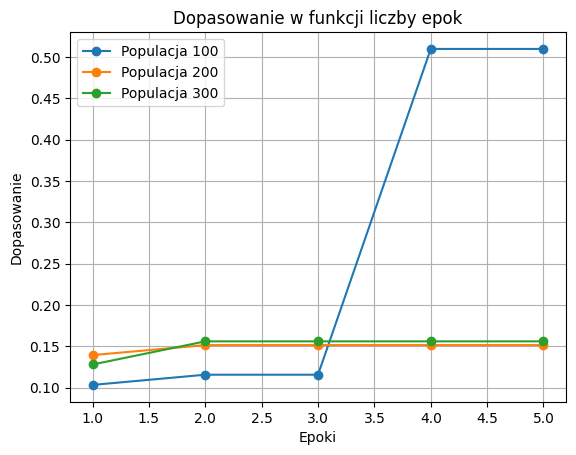

In [43]:
import matplotlib.pyplot as plt

# Dane dla pierwszego algorytmu
generations_1 = [1, 2, 3, 4, 5]
fitness_1 = [0.10328533379459515, 0.11563759592900268, 0.11563759592900268, 0.5097400325833825, 0.5097400325833825]

# Dane dla drugiego algorytmu
generations_2 = [1, 2, 3, 4, 5]
fitness_2 = [0.1393787410106364, 0.15145649090631305, 0.15145649090631305, 0.15145649090631305, 0.15145649090631305]

# Dane dla trzeciego algorytmu
generations_3 = [1, 2, 3, 4, 5]
fitness_3 = [0.12801034195133207, 0.1559887301757007, 0.1559887301757007,0.1559887301757007, 0.1559887301757007]

# Rysowanie wykresu
plt.plot(generations_1, fitness_1, marker='o', linestyle='-', label='Populacja 100')
plt.plot(generations_2, fitness_2, marker='o', linestyle='-', label='Populacja 200')
plt.plot(generations_3, fitness_3, marker='o', linestyle='-', label='Populacja 300')

plt.title('Dopasowanie w funkcji liczby epok')
plt.xlabel('Epoki')
plt.ylabel('Dopasowanie')
plt.legend()
plt.grid(True)
plt.show()